In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install "u8darts[all]"
!pip install optuna

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA A100-SXM4-40GB


In [5]:
import pandas as pd
import optuna
from darts import TimeSeries
from darts.models import CatBoostModel
from darts.metrics import mape, mae

In [6]:
df = pd.read_csv("drive/MyDrive/hse_diploma/data_after_selection.csv")
del df["Unnamed: 0"]
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df = df.sort_index()
df = df.asfreq('MS')
df.reset_index(drop=False, inplace=True)

In [ ]:
# Целевой ряд
target_series = TimeSeries.from_dataframe(df, 'time', 'inflation_rate')

# Экзогенные переменные
exog_vars = [col for col in df.columns if col not in ['time', 'inflation_rate']]
exog_series = TimeSeries.from_dataframe(df, 'time', exog_vars)

forecast_horizon = 6

train_val_target = target_series[:-forecast_horizon]
test_target = target_series[-(forecast_horizon+24):]

train_val_exog = exog_series[:-forecast_horizon]
test_exog = exog_series[-(forecast_horizon+24):]

train_target = train_val_target[:-forecast_horizon]
val_target = train_val_target[-(forecast_horizon+24):]

train_exog = train_val_exog[:-forecast_horizon]
val_exog = train_val_exog[-(forecast_horizon+24):]

In [8]:
import logging
import optuna
logging.basicConfig(level=logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [9]:
def objective(trial):
    lags = trial.suggest_int("lags", 6, 24)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    depth = trial.suggest_int("depth", 4, 10)
    iterations = trial.suggest_int("iterations", 200, 1000)

    model = CatBoostModel(
        lags=lags,
        lags_past_covariates=list(range(-lags, 0)),
        output_chunk_length=6,
        n_estimators=iterations,
        learning_rate=learning_rate,
        depth=depth,
        early_stopping_rounds=20,
        random_state=42,
        verbose=False
    )

    try:
        model.fit(series=train_target, past_covariates=train_exog, val_series=val_target, val_past_covariates=val_exog)
        pred = model.predict(n=6, series=train_target, past_covariates=train_exog)
        error = mape(target_series, pred, intersect=True)
        print(f"Trial {trial.number} — MAPE: {error:.1f}, params: lags={lags}, learning_rate={learning_rate}, depth={depth}, iterations={iterations}")
        return error
    except Exception as e:
        return float("inf")

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

print("Best params:", study.best_params)
print("Best MAPE:", study.best_value)


Trial 0 — MAPE: 13.6, params: lags=18, learning_rate=0.00828461816156557, depth=5, iterations=202
Trial 1 — MAPE: 13.3, params: lags=13, learning_rate=0.00012307620149982636, depth=6, iterations=781


[W 2025-05-23 16:37:26,192] Trial 2 failed with parameters: {'lags': 16, 'learning_rate': 0.0026311145062856123, 'depth': 9, 'iterations': 772} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-9-9dbabfee1aba>", line 20, in objective
    model.fit(series=train_target, past_covariates=train_exog, val_series=val_target, val_past_covariates=val_exog)
  File "/usr/local/lib/python3.11/dist-packages/darts/models/forecasting/catboost_model.py", line 332, in fit
    super().fit(
  File "/usr/local/lib/python3.11/dist-packages/darts/models/forecasting/regression_model.py", line 951, in fit
    self._fit_model(
  File "/usr/local/lib/python3.11/dist-packages/darts/models/forecasting/regression_model.py", line 1732, in _fit_model
    super()._fit_model(
  File "/usr/lo

KeyboardInterrupt: 

In [9]:
best_params = {'lags': 13, 'learning_rate': 0.0004569042795651829, 'depth': 5, 'iterations': 239}

**Validation**

In [10]:
best_model = CatBoostModel(
    lags=best_params["lags"],
    lags_past_covariates=list(range(-best_params["lags"], 0)),
    output_chunk_length=6,
    n_estimators=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    depth=best_params["depth"],
    random_state=42,
    verbose=False
)

best_model.fit(series=train_target, past_covariates=train_exog, val_series=val_target, val_past_covariates=val_exog)
forecast_val = best_model.predict(n=6, series=train_target, past_covariates=train_exog)
forecast_val_series = forecast_val.to_series()
smoothed_forecast_val_series = forecast_val_series.rolling(window=2, min_periods=0).mean()
smoothed_forecast_val_series = smoothed_forecast_val_series.round(1)
smoothed_forecast_val = TimeSeries.from_series(smoothed_forecast_val_series)

error_mape = mape(target_series, smoothed_forecast_val, intersect=True)
error_mae = mae(target_series, smoothed_forecast_val, intersect=True)

print(f"MAE на валидационной выборке: {error_mae:.2f}")
print(f"MAPE на валидационной выборке: {error_mape:.1f}")

MAE на валидационной выборке: 0.38
MAPE на валидационной выборке: 12.7


**Test**

In [11]:
best_model = CatBoostModel(
    lags=best_params["lags"],
    lags_past_covariates=list(range(-best_params["lags"], 0)),
    output_chunk_length=6,
    n_estimators=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    depth=best_params["depth"],
    random_state=42,
    verbose=False
)
best_model.fit(series=train_target, past_covariates=train_exog, val_series=val_target, val_past_covariates=val_exog)
forecast_test = best_model.predict(n=6, series=train_val_target, past_covariates=train_val_exog)
forecast_test_series = forecast_test.to_series()
smoothed_forecast_test_series = forecast_test_series.rolling(window=2, min_periods=0).mean()
smoothed_forecast_test_series = smoothed_forecast_test_series.round(1)
smoothed_forecast_test = TimeSeries.from_series(smoothed_forecast_test_series)

error_mape = mape(target_series, smoothed_forecast_test, intersect=True)
error_mae = mae(target_series, smoothed_forecast_test, intersect=True)

print(f"MAE на тестовой выборке: {error_mae:.2f}")
print(f"MAPE на тестовой выборке: {error_mape:.1f}")

MAE на тестовой выборке: 0.17
MAPE на тестовой выборке: 6.1


**Визуализация**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
dataset_for_vizual = df[["time", "inflation_rate"]].copy()
smoothed_forecast_val_frame = pd.DataFrame(smoothed_forecast_val_series)
smoothed_forecast_val_frame.rename(columns={"inflation_rate":"inflation_rate_val"}, inplace=True)
smoothed_forecast_test_frame = pd.DataFrame(smoothed_forecast_test_series)
smoothed_forecast_test_frame.rename(columns={"inflation_rate":"inflation_rate_test"}, inplace=True)
dataset_for_vizual = dataset_for_vizual.join(smoothed_forecast_val_frame, on="time", how="left").join(smoothed_forecast_test_frame, on="time", how="left")
dataset_for_vizual.set_index("time", inplace=True)
dataset_for_vizual.tail(10)

,inflation_rate,inflation_rate_val,inflation_rate_test
time,,,
2024-07-01,3.0,2.7,NaN
2024-08-01,2.9,2.7,NaN
2024-09-01,2.5,2.7,NaN
2024-10-01,2.4,2.7,NaN
2024-11-01,2.6,NaN,2.7
2024-12-01,2.7,NaN,2.7
2025-01-01,2.9,NaN,2.7
2025-02-01,3.0,NaN,2.7
2025-03-01,2.8,NaN,2.7


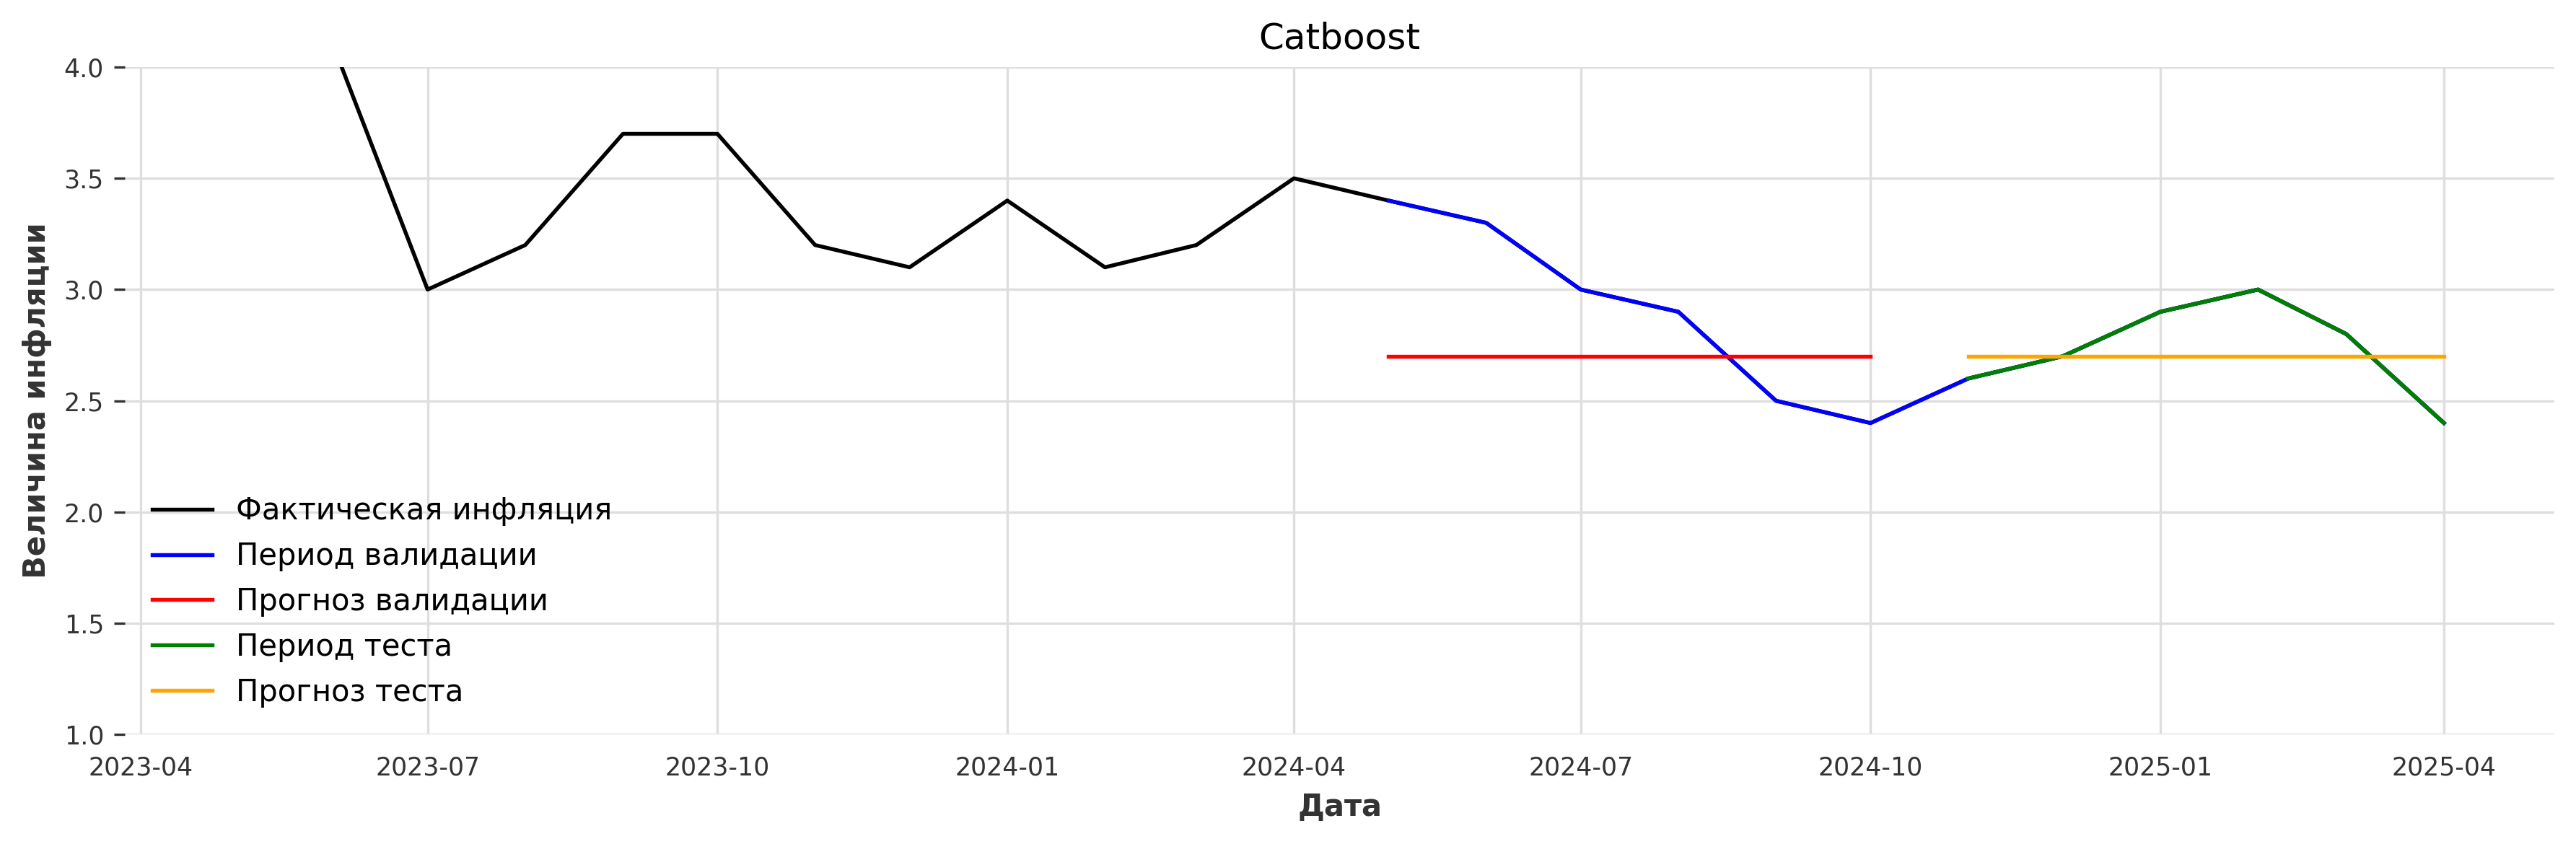

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(12, 4), dpi=300)

sns.lineplot(data=dataset_for_vizual.iloc[-4*forecast_horizon:],
             x=dataset_for_vizual.iloc[-4*forecast_horizon:].index,
             y='inflation_rate',
             label='Фактическая инфляция',
             color="black")

sns.lineplot(data=dataset_for_vizual.iloc[-2*forecast_horizon:],
             x=dataset_for_vizual.iloc[-2*forecast_horizon:].index,
             y='inflation_rate',
             label='Период валидации',
             color="blue")
sns.lineplot(data=dataset_for_vizual.iloc[-2*forecast_horizon:],
             x=dataset_for_vizual.iloc[-2*forecast_horizon:].index,
             y='inflation_rate_val',
             label='Прогноз валидации',
             color="red")

sns.lineplot(data=dataset_for_vizual.iloc[-forecast_horizon:],
             x=dataset_for_vizual.iloc[-forecast_horizon:].index,
             y='inflation_rate',
             label='Период теста',
             color="green")

sns.lineplot(data=dataset_for_vizual.iloc[-forecast_horizon:],
             x=dataset_for_vizual.iloc[-forecast_horizon:].index,
             y='inflation_rate_test',
             label='Прогноз теста',
             color="orange")

plt.xlabel('Дата')
plt.ylabel('Величина инфляции')
plt.title("Catboost")
plt.ylim(1, 4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("catboost.png", dpi=300, bbox_inches='tight')